# EXERCICE 7 : REGRESSION LINEAIRE MULTIPLE AVEC REGULARISATION + VALIDATION CROISEE


Inspire de http://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_and_elasticnet.html


In [2]:

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error


#### Génération de donnée synthétiques...

In [3]:

np.random.seed(31)

#... definition de n et p
n = 75
p =  200   #remarque : n<200 => necessite de selectionner des variables

#... simulation de X
X = np.random.randn(n, p) #remarque : on ne tient pas en compte les $beta_0$

#... generation du vecteur beta dans lequel seules 10 valeurs sont non-nulles
beta = 3 * np.random.randn(p)
inds = np.arange(p)
np.random.shuffle(inds)
beta[inds[10:]] = 0 

#... simulation de y 
y = np.dot(X, beta) + (2.0 * np.random.normal(size=n))


# REMARQUE IMPORTANTE : y ne dépend que des variables i pour lesquelles beta[i] est non-nul


# ... coupe en deux les donnees en donnees d'apprentissage et donnes test
thresh=n // 2
X_train = X[thresh:]
y_train = y[thresh:]
X_test = X[:thresh]
y_test = y[:thresh]


#### Régression linéaire avec régularisation Lasso ...


In [15]:

from sklearn.linear_model import Lasso

alpha = 0.5
lasso_regressor = Lasso(alpha=alpha)
lasso_regressor.fit(X_train, y_train)

y_pred_lasso = lasso_regressor.predict(X_test)
mse_score_lasso = mean_squared_error(y_test, y_pred_lasso)


####  Représentation du résultat


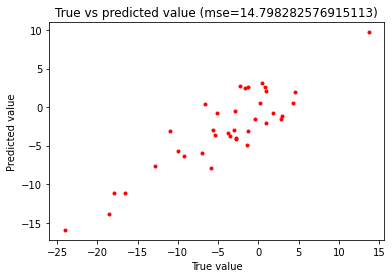

In [16]:
fig = plt.figure()
plt.plot(y_test, y_pred_lasso, 'r.')
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.title('True vs predicted value (mse='+str(mse_score_lasso)+')')
plt.show()



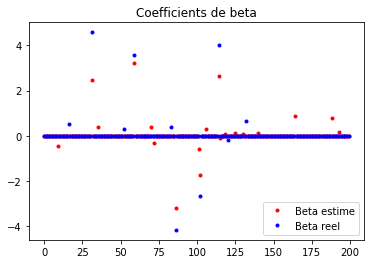

In [17]:

fig = plt.figure()
plt.plot(lasso_regressor.coef_, 'r.')
plt.plot(beta, 'b.')
plt.legend(('Beta estime', 'Beta reel'), loc='lower right')
plt.title('Coefficients de beta')
plt.show()



### <span style="color:blue">QUESTION 1</span> :

Jouez l'exemple avec  n=1000, n=100, n=75, n=50, n=25. Qu'en deduisez vous sur l'impact du nombre d'observations

### <span style="color:blue">REPONSE 1</span> :

Un nombre important d'observations conduit à réduire le biais du modèle.


### <span style="color:blue">QUESTION 2</span> :

On garde n=75. Utilisez la validation croisee de type K-folds (typiquement 8-Folds) pour trouver le meilleur coefficient *alpha* au sens de la MSE. Pour chaque *alpha* testé, on gardera comme score la MSE moyenne obtenue sur tous les *folds*.

Remarque : la recherche d'un bon coefficient *alpha* pourra d'abord se faire sur une échelle exponentielle assez large (ex: 0.001, 0.01, 0.1, ...) puis être raffinée sur une échelle plus fine.  

### <span style="color:blue">REPONSE 2</span> :

In [24]:

from sklearn.model_selection import KFold

kf = KFold(n_splits=8)
alpha_test = np.linspace(0.25,0.35,10)
MSE_mean_test = []

for alpha in alpha_test:
    current_MSE = []
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        #print(f"Fold {i}:")
        #print(f"  Train: index={train_index}")
        #print(f"  Test:  index={test_index}")
        
        lasso_regressor = Lasso(alpha=alpha)
        lasso_regressor.fit(X[train_index], y[train_index])

        y_pred_lasso = lasso_regressor.predict(X[test_index])
        current_MSE.append(mean_squared_error(y[test_index], y_pred_lasso))
        
    MSE_mean_test.append(np.mean(np.array(current_MSE)))

print(MSE_mean_test)



[8.877750116673335, 8.8416028835091, 8.828611796320848, 8.820211766068443, 8.828499901443854, 8.835507423505963, 8.851403020462325, 8.890104254316263, 8.925926875363912, 8.96901179472852]


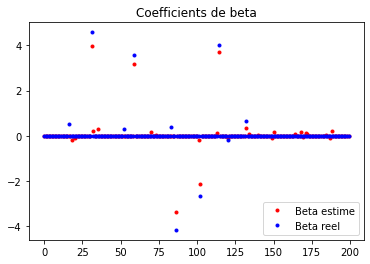

In [26]:
#représentation des coefficients estimés (lasso_regressor.coef_) et de ceux
#avec lesquels les données ont été simulées (beta)

        
fig = plt.figure()
plt.plot(lasso_regressor.coef_, 'r.')
plt.plot(beta, 'b.')
plt.legend(('Beta estime', 'Beta reel'), loc='lower right')
plt.title('Coefficients de beta')
plt.show()


### <span style="color:blue">QUESTION 3</span> :

De manère alternative, codez et testez maintenant une sélection de type *forward* avec un critère de sélection *BIC*.

Comparez les résultats avec ceux obtenus à l'aide de la pénalisation LASSO.

### <span style="color:blue">REPONSE 3</span> :


In [9]:


from sklearn.linear_model import LinearRegression

n = 75
p = 200

var_kept = []
bic = np.inf

min_mse = np.inf
current_var_kept = 0

for k in range(p):
    lr = LinearRegression()
    X_tmp = X[:,k]
    lr.fit(X_tmp[:,np.newaxis],y)
    y_pred = lr.predict(X_tmp[:,np.newaxis])
    mse = mean_squared_error(y_pred,y)
    if mse < min_mse:
        current_var_kept = k
        min_mse = mse

current_bic = n*np.log(min_mse) + np.log(n)*2
if current_bic < bic:
    bic = current_bic
    var_kept.append(current_var_kept)

q = 1
while (current_bic <= bic) and (q<p):
    q += 1
    min_mse = np.inf
    current_var_kept = -1

    for k in range(p):
        if k not in var_kept:
            lr = LinearRegression()
            var_kept_temp = var_kept.copy()
            var_kept_temp.append(k)
            X_tmp = X[:,var_kept_temp]
            lr.fit(X_tmp,y)
            y_pred = lr.predict(X_tmp)
            mse = mean_squared_error(y_pred,y)
            if mse < min_mse:
                current_var_kept = k
                min_mse = mse

    current_bic = n*np.log(min_mse) + np.log(n)*(q+1)
    #print(current_bic)
    #print(bic)
    if current_bic < bic:
        bic = current_bic
        var_kept.append(current_var_kept)

    #print(var_kept)
    #print(bic)
    
print(f"{q-1} variables are relevant : {var_kept}")

75 variables are relevant : [114, 59, 86, 31, 102, 132, 83, 101, 184, 155, 32, 134, 118, 164, 150, 67, 191, 186, 9, 10, 185, 152, 20, 16, 35, 65, 189, 41, 53, 8, 116, 104, 151, 19, 70, 135, 18, 197, 77, 46, 110, 176, 163, 122, 196, 5, 121, 25, 39, 133, 144, 15, 98, 188, 26, 175, 157, 27, 21, 81, 84, 187, 82, 76, 97, 183, 154, 87, 166, 49, 182, 167, 123, 111, 137]
